#Import Library

In [362]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,mean_squared_error,roc_curve,roc_auc_score,classification_report,r2_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

- UID: unique identifier ranging from 1 to 10000 productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

# Data Understanding

In [363]:
df = pd.read_csv("predictive_maintenance.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [365]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


# Data Cleaning

In [366]:
df.duplicated().sum()

0

In [367]:
df.isna().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


In [368]:
tft = df[(df['Target'] != 0) & (df['Failure Type'] == 'No Failure')]
tft

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,2750,M17609,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,4045,M18904,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,4685,M19544,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,5537,M20396,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,8507,L55686,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,9016,L56195,L,297.2,308.1,1431,49.7,210,1,No Failure


In [369]:
rf = df[df['Failure Type']=='Random Failures']
rf

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1221,1222,M16081,M,297.0,308.3,1399,46.4,132,0,Random Failures
1302,1303,L48482,L,298.6,309.8,1505,45.7,144,0,Random Failures
1748,1749,H31162,H,298.4,307.7,1626,31.1,166,0,Random Failures
2072,2073,L49252,L,299.6,309.5,1570,35.5,189,0,Random Failures
2559,2560,L49739,L,299.3,309.0,1447,50.4,140,0,Random Failures
3065,3066,M17925,M,300.1,309.2,1687,27.7,95,0,Random Failures
3452,3453,H32866,H,301.6,310.5,1602,32.3,2,0,Random Failures
5471,5472,L52651,L,302.7,312.3,1346,61.2,170,0,Random Failures
5489,5490,L52669,L,302.6,312.1,1499,35.0,215,0,Random Failures
5495,5496,H34909,H,302.9,312.5,1357,55.0,12,0,Random Failures


In [370]:
df = df.drop(['UDI','Product ID'], axis=1)
df = df.drop(rf.index)
df = df.drop(tft.index)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


# Data Manipulation

In [371]:
df["Air temperature [K]"] = df["Air temperature [K]"] - 273.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 273.15

df.rename(columns={"Air temperature [K]" : "Air temperature [C]","Process temperature [K]" : "Process temperature [C]"},inplace=True)
df.head()

,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,24.95,35.45,1551,42.8,0,0,No Failure
1,L,25.05,35.55,1408,46.3,3,0,No Failure
2,L,24.95,35.35,1498,49.4,5,0,No Failure
3,L,25.05,35.45,1433,39.5,7,0,No Failure
4,L,25.05,35.55,1408,40.0,9,0,No Failure


In [372]:
ttw_grouped = df.groupby('Type')['Tool wear [min]'].mean().reset_index()
ttw_grouped

,Type,Tool wear [min]
0,H,107.696393
1,L,108.283255
2,M,107.271481


In [373]:
tat_grouped = df.groupby('Type')['Air temperature [C]'].mean().reset_index()
tat_grouped

,Type,Air temperature [C]
0,H,26.714228
1,L,26.864188
2,M,26.877783


In [374]:
tpt_grouped = df.groupby('Type')['Process temperature [C]'].mean().reset_index()
tpt_grouped

,Type,Process temperature [C]
0,H,36.772846
1,L,36.860378
2,M,36.868422


In [375]:
trs_grouped = df.groupby('Type')['Rotational speed [rpm]'].mean().reset_index()
trs_grouped

,Type,Rotational speed [rpm]
0,H,1538.376754
1,L,1539.584225
2,M,1537.683049


# Split Data

In [376]:
X = df.drop(["Target","Type","Failure Type"],axis = 1)
y = df["Target"]

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape

((6981, 5), (2992, 5))

In [378]:
X_train.head()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min]
5877,28.35,37.95,1458,41.4,123
5320,30.25,39.55,1363,45.5,26
8930,24.25,35.25,1571,39.4,0
5166,31.05,40.35,1546,41.4,58
5128,31.05,40.25,1434,42.5,175


# Exploratory Data Analysis

In [379]:
categoricals = ['Type','Failure Type']

numericals = ['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Target']

In [380]:
df[categoricals].describe()

,Type,Failure Type
count,9973,9973
unique,3,5
top,L,No Failure
freq,5984,9643


In [381]:
for col in categoricals:
  print(f"Value counts of {col} column")
  print(df[col].value_counts(), '\n')

Value counts of Type column
Type
L    5984
M    2991
H     998
Name: count, dtype: int64 

Value counts of Failure Type column
Failure Type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64 



## Univariate Analysis

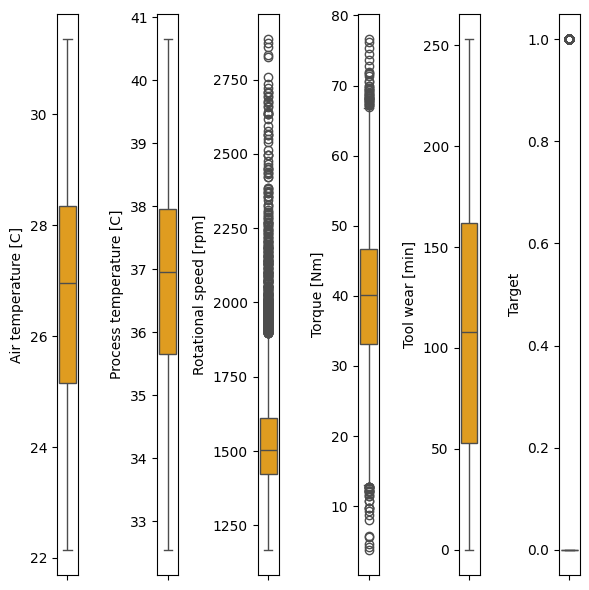

In [382]:
plt.figure(figsize=(6,6))

features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='orange')
    plt.tight_layout()

Konsistensi Data: Sebagian besar fitur numerik memiliki distribusi yang relatif stabil, dengan beberapa outliers yang mungkin perlu diperiksa lebih lanjut.

Outliers: Outliers pada Rotational Speed dan Torque bukan menunjukkan kondisi abnormal atau kesalahan pengukuran karena setiap produk memiliki proses dan penyesuaiannya masing-masing.

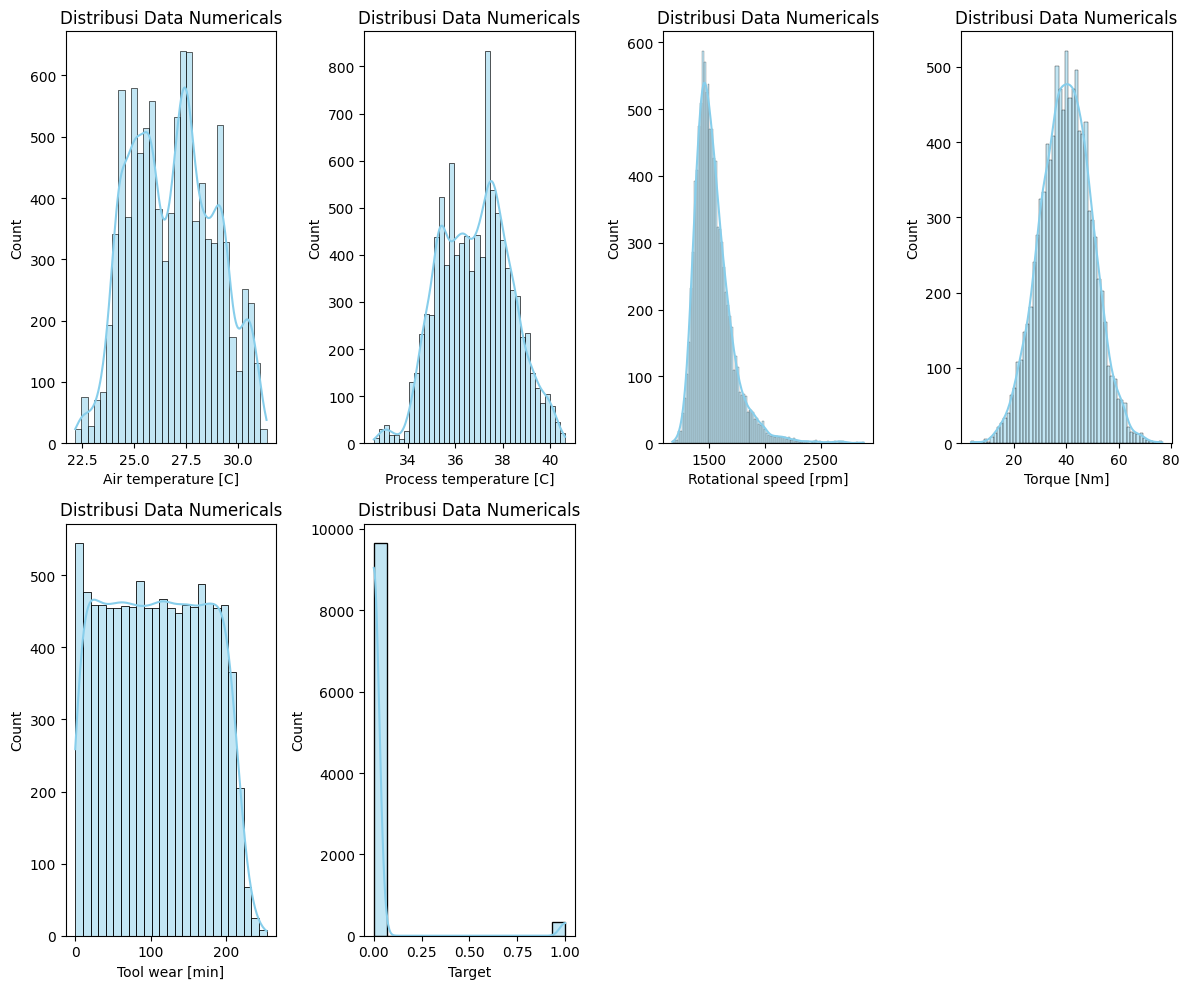

In [383]:
plt.figure(figsize=(12,10))

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.histplot(x=df[features[i]], color='skyblue', kde=True)
    plt.xlabel(features[i])
    plt.title('Distribusi Data Numericals')
    plt.tight_layout()

- Air Temperature [°C]:Distribusi data cenderung simetris dengan puncak di sekitar 26-28 °C.Variasi suhu udara terlihat sempit, menunjukkan bahwa data terkonsentrasi di sekitar nilai tengah ini.
Insight: Kondisi suhu udara selama proses mungkin relatif stabil di sekitar kisaran tersebut.

- Process Temperature [°C]:Distribusi data memiliki beberapa puncak (bimodal atau multimodal), dengan nilai utama berada di sekitar 36-38 °C.Variasi suhu proses lebih besar dibandingkan suhu udara.
Insight: Bisa jadi ada beberapa kondisi operasi yang menghasilkan pola distribusi ini.

- Rotational Speed [rpm]:
Distribusi data memiliki skewness negatif (condong ke kiri), dengan sebagian besar nilai berada di antara 1500-2000 rpm.Ada sebagian kecil data yang menunjukkan kecepatan rotasi tinggi di atas 2000 rpm.
Insight: Kecepatan rotasi alat lebih sering berada di level sedang dibandingkan level ekstrem.

- Torque [Nm]:
Distribusi data berbentuk normal (bell-shaped), dengan puncak di sekitar 40-50 Nm.Variasi distribusi terlihat simetris, menunjukkan bahwa torque memiliki rentang variasi yang seimbang.
Insight: Torsi alat ini mungkin memiliki standar operasi yang konsisten di sekitar kisaran ini.

- Tool Wear [min]:
Distribusi data menunjukkan skewness negatif, dengan sebagian besar nilai berada di antara 0-150 menit. Jumlah alat yang mengalami keausan lebih tinggi dari 200 menit relatif sedikit.
Insight: Sebagian besar alat digunakan dalam rentang waktu pendek hingga menengah sebelum terjadi keausan yang signifikan.

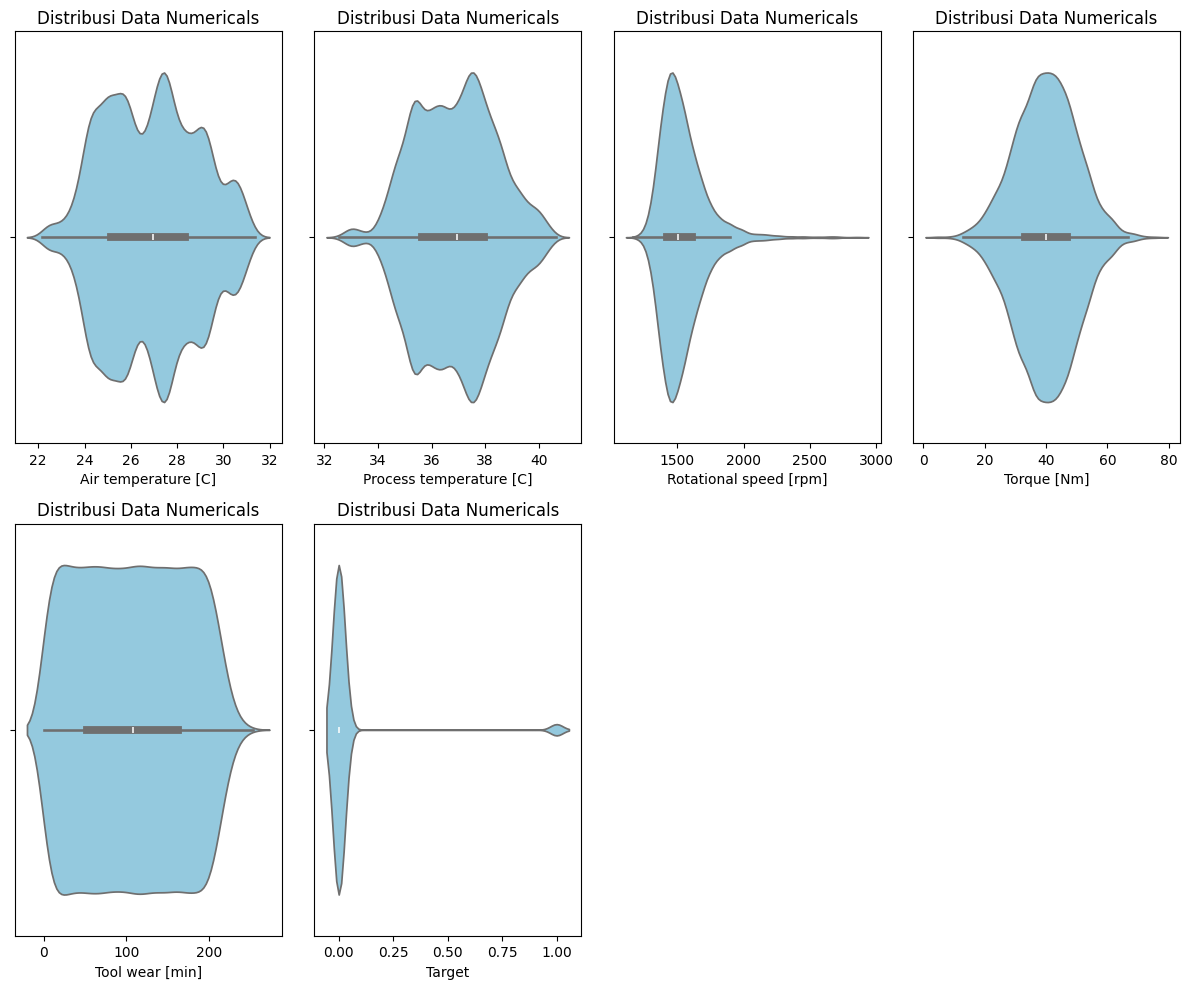

In [384]:
plt.figure(figsize=(12,10))

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.violinplot(x=df[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.title('Distribusi Data Numericals')
    plt.tight_layout()

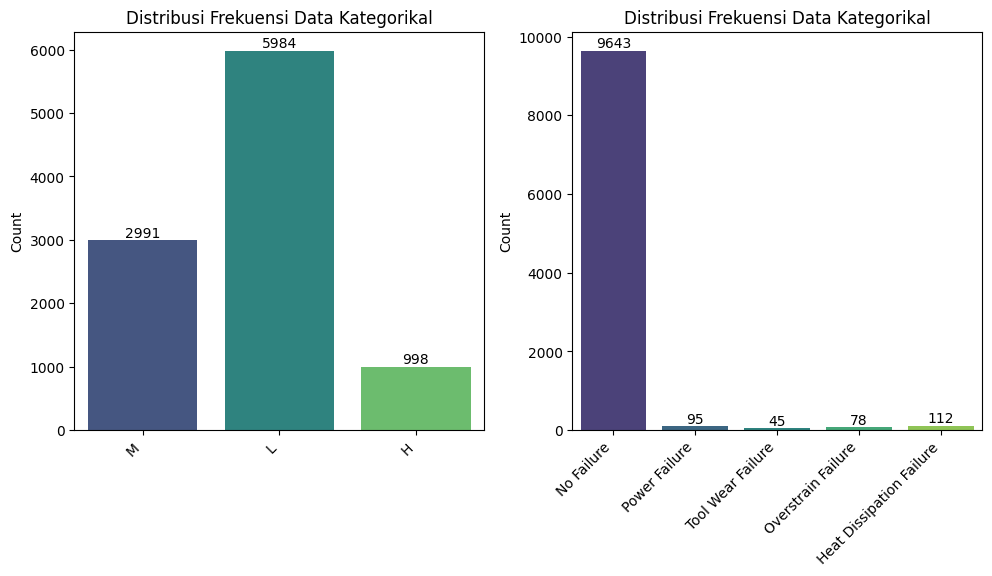

In [385]:
plt.figure(figsize=(15, 10))
plots_per_row = 3
rows = (len(categoricals) + plots_per_row + 1)//plots_per_row
for i in range(0, len(categoricals)):
    plt.subplot(rows, plots_per_row, i+1)
    ax = sns.countplot(x=df[categoricals[i]], width=0.8, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.title('Distribusi Frekuensi Data Kategorikal')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f')
    plt.tight_layout()

- Grafik1 :
Mayoritas data termasuk dalam kategori L, yang menunjukkan bahwa sebagian besar kasus berada dalam kategori rendah.
Proporsi kategori H relatif kecil, sehingga mungkin merepresentasikan situasi atau kondisi tertentu yang lebih jarang terjadi.

- Grafik2:
Sebagian besar proses berjalan tanpa kegagalan, yang mencerminkan tingkat keandalan tinggi pada kondisi tertentu.
Kegagalan paling umum adalah Heat Dissipation Failure (112), sementara Random Failures sangat jarang terjadi.
Perlu fokus pada penyebab utama kegagalan, khususnya Heat Dissipation Failure dan Overstrain Failure, untuk meningkatkan performa sistem.

## Multivariate Analysis

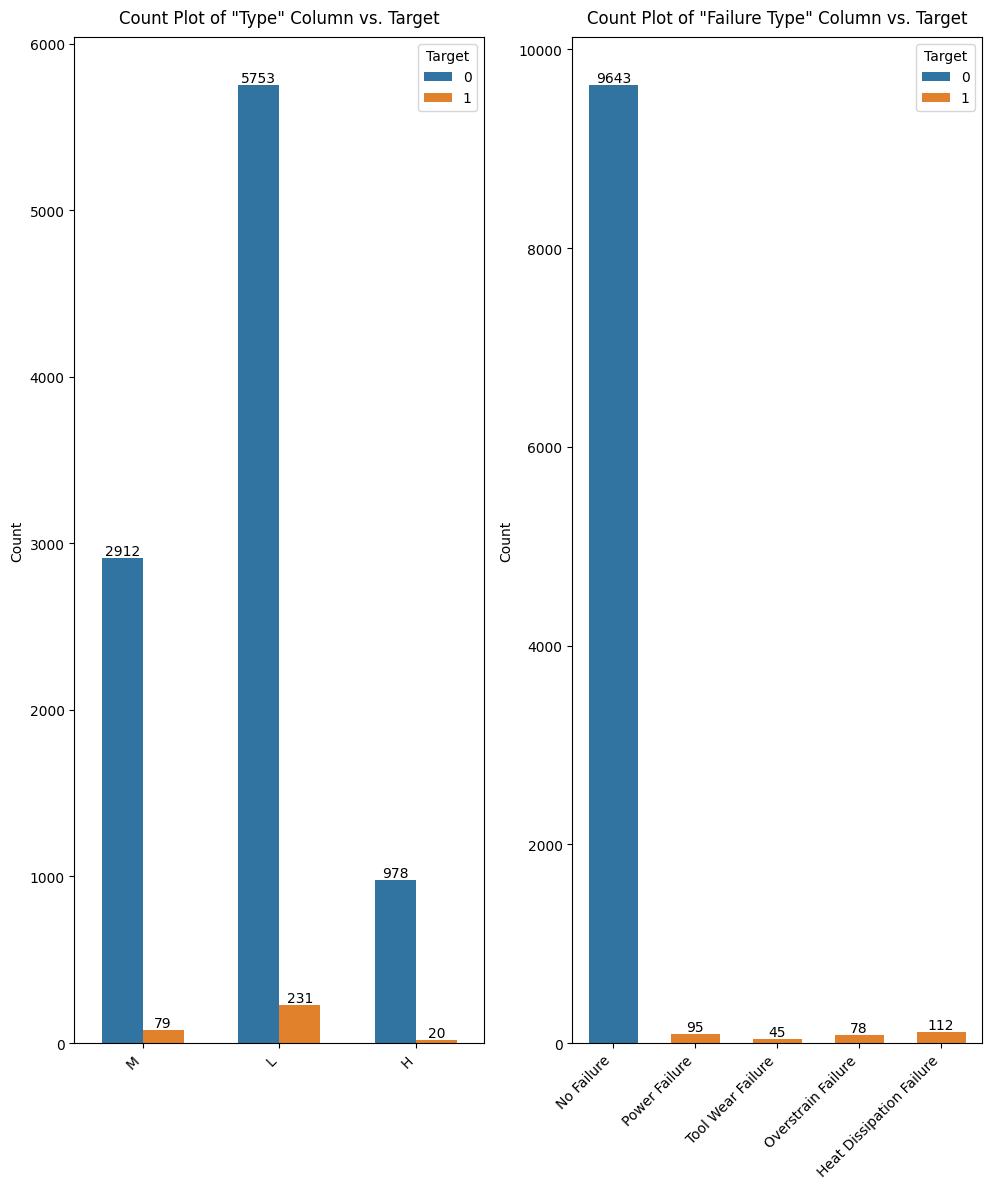

In [386]:
plt.figure(figsize=(15, 12))
features = categoricals
plots_per_row = 3
rows = (len(features) + plots_per_row - 1) // plots_per_row
hue_var = "Target"

for i in range(len(features)):
    plt.subplot(rows, plots_per_row, i + 1)
    ax = sns.countplot(x=df[features[i]], hue=df[hue_var], width=0.6)
    plt.title(f'Count Plot of "{features[i]}" Column vs. Target', pad=10)
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f')
        plt.tight_layout()

## Correlation HeatMap

<Axes: >

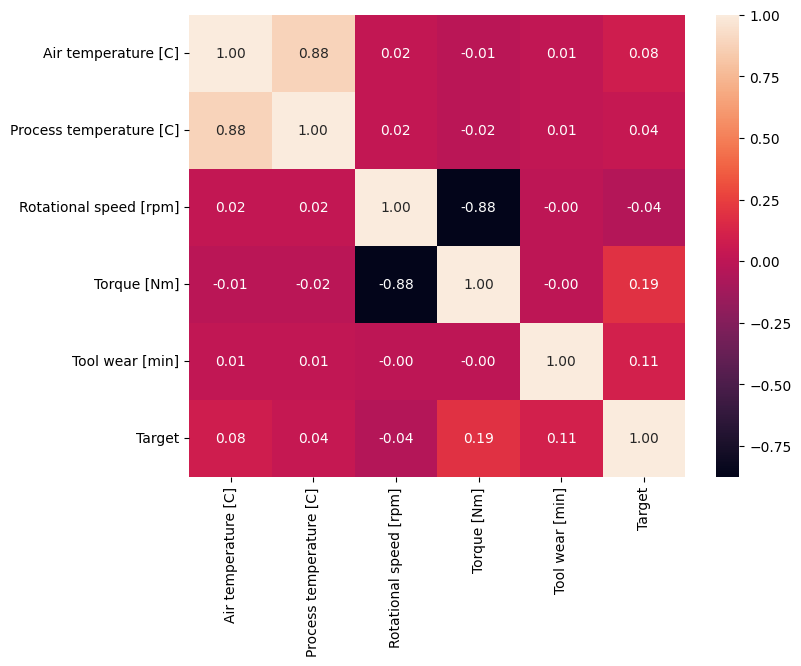

In [387]:
plt.figure(figsize=(8,6))
correlation = df[numericals].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

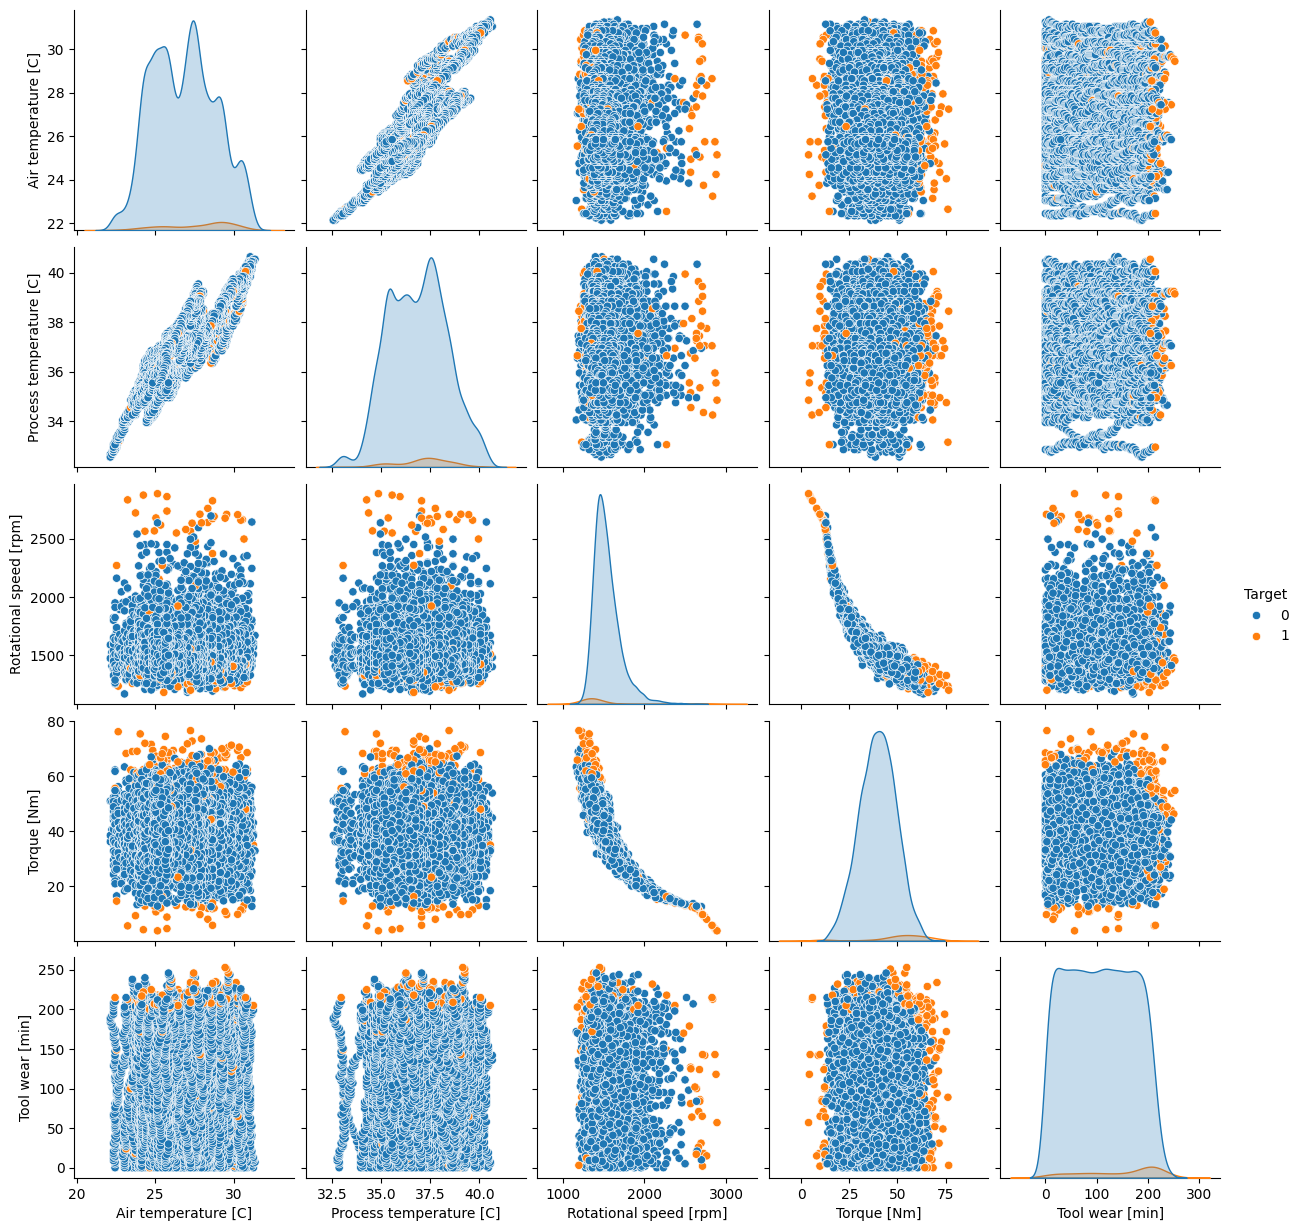

In [388]:
# pairplot of the data
sns.pairplot(df, hue='Target')

Insight dari Pairwise Scatter Plot
Air Temperature vs Process Temperature:

Hubungan linier terlihat di mana suhu proses meningkat seiring meningkatnya suhu udara.
Titik dengan target 1 tersebar di berbagai nilai, tetapi lebih banyak terlihat di kisaran suhu proses tinggi.
Rotational Speed vs Torque:

Ada hubungan negatif kuat: ketika kecepatan rotasi tinggi, torsi cenderung lebih rendah, dan sebaliknya.
Titik dengan target 1 lebih sering muncul pada torsi rendah dan kecepatan rotasi tinggi.
Torque vs Tool Wear:

Sebaran titik menunjukkan bahwa keausan alat (tool wear) tinggi cenderung terkait dengan torsi lebih rendah.
Data dengan target 1 lebih dominan pada alat dengan keausan tinggi.
Rotational Speed vs Tool Wear:

Sebagian besar titik terkonsentrasi pada keausan alat rendah hingga menengah.
Target 1 lebih sering ditemukan pada alat dengan keausan tinggi dan kecepatan rotasi tinggi.
3. Insight dari Histogram (Distribusi Univariat)
Air Temperature dan Process Temperature:

Distribusi terlihat dengan beberapa puncak (multimodal).
Target 1 muncul di berbagai nilai, tetapi lebih sering terlihat pada ujung distribusi.
Rotational Speed:

Distribusi menunjukkan skewness negatif dengan konsentrasi data di kecepatan rotasi sedang (1500-2000 rpm).
Target 1 lebih dominan pada kecepatan rotasi ekstrem (tinggi).
Torque:

Distribusi berbentuk normal dengan puncak di sekitar 40-50 Nm.
Target 1 lebih banyak terlihat pada ujung distribusi (torsi sangat rendah atau tinggi).
Tool Wear:

Distribusi menunjukkan skewness negatif dengan konsentrasi data di keausan rendah hingga sedang.
Target 1 lebih banyak terjadi pada keausan tinggi.
4. Rekomendasi
Analisis Kegagalan:
Investigasi lebih lanjut diperlukan untuk memahami kondisi operasional pada torsi rendah/kecepatan tinggi dan keausan alat tinggi, karena ini sering berkaitan dengan kegagalan (target 1).
Pemantauan Variabel:
Variabel Rotational Speed, Torque, dan Tool Wear dapat menjadi indikator penting untuk memprediksi kegagalan.
Model Prediksi:
Data dengan hubungan yang kuat, seperti Rotational Speed vs Torque dan Tool Wear vs Torque, dapat digunakan untuk membangun model prediksi kegagalan yang lebih akurat.

# Feature Engineering

In [389]:
X_train['Torque [Nm]'].describe()

,Torque [Nm]
count,6981.000000
mean,39.982567
std,9.942301
min,4.200000
25%,33.100000
50%,40.000000
75%,46.800000
max,75.400000


In [390]:
torque_group_data = [None] * len(df)
for i in range(len(df)):
    if df['Torque [Nm]'].iloc[i] < 35:
        torque_group_data[i] = 'Low'
    elif df['Torque [Nm]'].iloc[i] >=35 and df['Torque [Nm]'].iloc[i] < 50:
        torque_group_data[i] = 'Medium'
    elif df['Torque [Nm]'].iloc[i] >=50 and df['Torque [Nm]'].iloc[i] < 75:
        torque_group_data[i] = 'High'
    elif df['Torque [Nm]'].iloc[i] >=75:
        torque_group_data[i] = 'Very High'
    else:
        torque_group_data[i] = 'Abnormal'

df['Torque [Nm]'] = torque_group_data

In [391]:
df['Tool wear [min]'].describe()

,Tool wear [min]
count,9973.000000
mean,107.921087
std,63.649152
min,0.000000
25%,53.000000
50%,108.000000
75%,162.000000
max,253.000000


In [392]:
tw_group_data = [None] * len(df)
for i in range(len(df)):
    # Use .iloc to access data by position
    if df['Tool wear [min]'].iloc[i] < 60:
        tw_group_data[i] = 'Short process'
    elif df['Tool wear [min]'].iloc[i] >= 60 and df['Tool wear [min]'].iloc[i] < 120:
        tw_group_data[i] = 'Medium process'
    elif df['Tool wear [min]'].iloc[i] >= 120 and df['Tool wear [min]'].iloc[i] < 180:
        tw_group_data[i] = 'Long Process'
    elif df['Tool wear [min]'].iloc[i] >= 180:
        tw_group_data[i] = 'Very long process'
    else:
        tw_group_data[i] = 'Abnormal'

df['Tool wear [min]'] = tw_group_data

# One Hot Encoding

In [393]:
df.head()

,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,24.95,35.45,1551,Medium,Short process,0,No Failure
1,L,25.05,35.55,1408,Medium,Short process,0,No Failure
2,L,24.95,35.35,1498,Medium,Short process,0,No Failure
3,L,25.05,35.45,1433,Medium,Short process,0,No Failure
4,L,25.05,35.55,1408,Medium,Short process,0,No Failure


In [394]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Heat Dissipation Failure'], dtype=object)

In [395]:
f = pd.get_dummies(df['Failure Type'], prefix="ft_dummy")
tq = pd.get_dummies(df['Torque [Nm]'], prefix="ft_dummy")
tw = pd.get_dummies(df['Tool wear [min]'], prefix="ft_dummy")

In [396]:
frames = [df, f, tq, tw]
df_new = pd.concat(frames, axis = 1)
df_new = df_new.drop(["Failure Type","Torque [Nm]", "Tool wear [min]"],axis = 1)
df_new.head()

,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Target,ft_dummy_Heat Dissipation Failure,ft_dummy_No Failure,ft_dummy_Overstrain Failure,ft_dummy_Power Failure,ft_dummy_Tool Wear Failure,ft_dummy_High,ft_dummy_Low,ft_dummy_Medium,ft_dummy_Very High,ft_dummy_Long Process,ft_dummy_Medium process,ft_dummy_Short process,ft_dummy_Very long process
0,M,24.95,35.45,1551,0,False,True,False,False,False,False,False,True,False,False,False,True,False
1,L,25.05,35.55,1408,0,False,True,False,False,False,False,False,True,False,False,False,True,False
2,L,24.95,35.35,1498,0,False,True,False,False,False,False,False,True,False,False,False,True,False
3,L,25.05,35.45,1433,0,False,True,False,False,False,False,False,True,False,False,False,True,False
4,L,25.05,35.55,1408,0,False,True,False,False,False,False,False,True,False,False,False,True,False


# Modeling

## Logistic Regression

In [397]:
log_reg = LogisticRegression().fit(X_train,y_train)
y_pred = log_reg.predict(X_test)
log_model = (accuracy_score(y_test,y_pred)*100)
log_model

97.25935828877004

### Evaluation

In [398]:
y_probs = log_reg.predict_proba(X_test)[:,1]
y_pred = [1 if i >0.53 else 0 for i in y_probs]
log_reg_train = round(log_reg.score(X_train, y_train) * 100, 2)
log_reg_accuracy = round(accuracy_score(y_pred, y_test) * 100, 2)
print("Training Accuracy    :",log_reg_train)
print("Model Accuracy Score :",log_reg_accuracy)
print(classification_report(y_test, y_pred))

Training Accuracy    : 97.05
Model Accuracy Score : 97.29
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2903
           1       0.68      0.17      0.27        89

    accuracy                           0.97      2992
   macro avg       0.83      0.58      0.63      2992
weighted avg       0.97      0.97      0.96      2992



## Support Vector Machines

In [399]:
from sklearn.svm import SVC # "Support vector classifier"
svm_model_linear = SVC(kernel='linear').fit(X_train,y_train)
svm_model_poly = SVC(kernel='poly').fit(X_train,y_train)
svm_model_rbf = SVC(kernel='rbf').fit(X_train,y_train)

In [400]:
y_pred_linear = svm_model_linear.predict(X_test)
y_pred_poly = svm_model_poly.predict(X_test)
y_pred_rbf = svm_model_rbf.predict(X_test)

### Evaluation

In [401]:
SVM_train = round(model.score(X_train, y_train) * 100, 2)
SVM_linear_accuracy = round(accuracy_score(y_pred_linear, y_test) * 100, 2)
SVM_poly_accuracy = round(accuracy_score(y_pred_poly, y_test) * 100, 2)
SVM_rbf_accuracy = round(accuracy_score(y_pred_rbf, y_test) * 100, 2)
print("Training Accuracy    :",SVM_train)
print("Model Linear Accuracy Score :",SVM_linear_accuracy)
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred_linear))
print("\033[1m--------------------------------------------------------\033[0m")
print("Model Poly Accuracy Score :",SVM_poly_accuracy)
print(classification_report(y_test, y_pred_poly))
print("\033[1m--------------------------------------------------------\033[0m")
print("Model rbf Accuracy Score :",SVM_rbf_accuracy)
print(classification_report(y_test, y_pred_rbf))
print("\033[1m--------------------------------------------------------\033[0m")

Training Accuracy    : 100.0
Model Linear Accuracy Score : 97.39
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2903
           1       0.79      0.17      0.28        89

    accuracy                           0.97      2992
   macro avg       0.88      0.58      0.63      2992
weighted avg       0.97      0.97      0.97      2992

--------------------------------------------------------
Model Poly Accuracy Score : 97.03
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2903
           1       0.00      0.00      0.00        89

    accuracy                           0.97      2992
   macro avg       0.49      0.50      0.49      2992
weighted avg       0.94      0.97      0.96      2992

--------------------------------------------------------
Model rbf Accuracy Score : 97.03
              precision    recall  f1-score

## Random Forest

In [402]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [403]:
y_pred = model.predict(X_test)

### Evaluasi

In [404]:
# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy * 100}')

Akurasi: 98.83021390374331


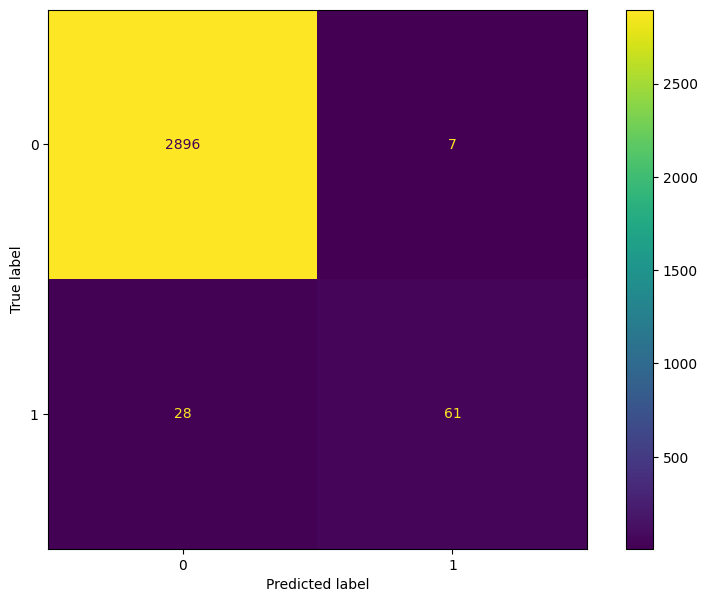

In [405]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,7))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot(ax=ax)
plt.show()

In [406]:
y_pred = model.predict(X_test)
random_forest_train = round(model.score(X_train, y_train) * 100, 2)
random_forest_accuracy = round(accuracy_score(y_pred, y_test) * 100, 2)
print("Training Accuracy    :",random_forest_train)
print("Model Accuracy Score :",random_forest_accuracy)
print(classification_report(y_test, y_pred))

Training Accuracy    : 100.0
Model Accuracy Score : 98.83
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2903
           1       0.90      0.69      0.78        89

    accuracy                           0.99      2992
   macro avg       0.94      0.84      0.89      2992
weighted avg       0.99      0.99      0.99      2992



# Summary and Recommendation

In [407]:
original_df = pd.read_csv("predictive_maintenance.csv")

X_test['Target'] = y_pred
# Merge to get 'Product ID' and 'Failure Type'
X_test = X_test.merge(original_df[['Product ID', 'Failure Type']], left_index=True, right_index=True)

result = X_test[['Target','Failure Type']]
result

,Target,Failure Type
3363,0,No Failure
2410,0,No Failure
4383,1,Heat Dissipation Failure
107,0,No Failure
9418,0,No Failure
...,...,...
751,0,No Failure
5771,0,No Failure
4020,0,No Failure
9790,0,No Failure


In [408]:
X_test['Target'].value_counts()

,count
Target,
0,2924
1,68


In [409]:
X_test['Failure Type'].value_counts()

,count
Failure Type,
No Failure,2903
Heat Dissipation Failure,32
Power Failure,32
Overstrain Failure,13
Tool Wear Failure,12
